In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback
from keras.applications.vgg16 import VGG16

2024-02-19 16:27:30.799531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 16:27:30.799564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 16:27:30.800809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 16:27:30.808268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:27:31.986639: W tensorflow/compiler/tf2

In [2]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [3]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [4]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data_rgb = np.stack((train_data,) * 3, axis=-1)
test_data_rgb = np.stack((test_data,) * 3, axis=-1)

train_data_rgb = tf.image.resize(train_data_rgb, (32, 32))
test_data_rgb = tf.image.resize(test_data_rgb, (32, 32))

train_data_rgb, test_data_rgb = train_data_rgb / 255., test_data_rgb / 255.

train_labels_one_hot = to_categorical(train_labels, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)

2024-02-19 16:27:33.944541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 16:27:33.987669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 16:27:33.987892: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(10)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(10)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [6]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

class MyFilterModelMP():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(
                units=64,
                activation='relu'
            ),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    vertical_flip=True
)

train_generator = datagen.flow(train_data_rgb, train_labels_one_hot, batch_size=32)
test_generator = datagen.flow(test_data_rgb, test_labels_one_hot, batch_size=32)

2024-02-19 16:28:53.925891: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


In [10]:
filtermodel = MyFilterModelMP()
model_filter = filtermodel.build()
history = model_filter.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=50,
    epochs=100,
    batch_size=32
)

Epoch 1/100


/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-02-19 16:29:03.418153: I external/local_xla/xla/service/service.cc:168] XLA service 0x5590d00ddab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 16:29:03.418175: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-02-19 16:29:03.568990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-19 16:29:03.904363: I external/local_xla/xla/stream_executor/c

 14/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2651 - loss: 2.2266 - precision_class_0: 0.0000e+00 - precision_class_1: 0.0000e+00 - precision_class_2: 0.0000e+00 - precision_class_3: 0.0000e+00 - precision_class_4: 0.0000e+00 - precision_class_5: 0.0000e+00 - precision_class_6: 0.0000e+00 - precision_class_7: 0.0000e+00 - precision_class_8: 0.0000e+00 - precision_class_9: 0.0000e+00 - recall_class_0: 0.0000e+00 - recall_class_1: 0.0000e+00 - recall_class_2: 0.0000e+00 - recall_class_3: 0.0000e+00 - recall_class_4: 0.0000e+00 - recall_class_5: 0.0000e+00 - recall_class_6: 0.0000e+00 - recall_class_7: 0.0000e+00 - recall_class_8: 0.0000e+00 - recall_class_9: 0.0000e+00

I0000 00:00:1708352946.870761    7408 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.4201 - loss: 1.8487 - precision_class_0: 0.1188 - precision_class_1: 0.8356 - precision_class_2: 0.4653 - precision_class_3: 0.4858 - precision_class_4: 0.0000e+00 - precision_class_5: 0.1191 - precision_class_6: 0.0000e+00 - precision_class_7: 0.4753 - precision_class_8: 0.3898 - precision_class_9: 0.4380 - recall_class_0: 4.1345e-04 - recall_class_1: 0.2783 - recall_class_2: 0.0350 - recall_class_3: 0.0185 - recall_class_4: 0.0000e+00 - recall_class_5: 0.0043 - recall_class_6: 0.0000e+00 - recall_class_7: 0.1058 - recall_class_8: 0.0202 - recall_class_9: 0.0500 - val_accuracy: 0.6538 - val_loss: 1.0775 - val_precision_class_0: 1.0000 - val_precision_class_1: 0.9931 - val_precision_class_2: 0.7792 - val_precision_class_3: 0.7647 - val_precision_class_4: 0.6000 - val_precision_class_5: 0.8472 - val_precision_class_6: 0.0000e+00 - val_precision_class_7: 0.9074 - val_precision_class_8: 0.8615 - val_precision_class_9: 0.9669 - val_r

2024-02-19 16:29:24.604003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:29:24.604036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960
/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7756 - loss: 0.6264 - precision_class_0: 0.7639 - precision_class_1: 0.9628 - precision_class_2: 0.7728 - precision_class_3: 0.7935 - precision_class_4: 0.7150 - precision_class_5: 0.8775 - precision_class_6: 0.5761 - precision_class_7: 0.8496 - precision_class_8: 0.9152 - precision_class_9: 0.9051 - recall_class_0: 0.6042 - recall_class_1: 0.9102 - recall_class_2: 0.5317 - recall_class_3: 0.7021 - recall_class_4: 0.5927 - recall_class_5: 0.8778 - recall_class_6: 0.2308 - recall_class_7: 0.8378 - recall_class_8: 0.7407 - recall_class_9: 0.8457 - val_accuracy: 0.7506 - val_loss: 0.6800 - val_precision_class_0: 0.8553 - val_precision_class_1: 0.9497 - val_precision_class_2: 0.7438 - val_precision_class_3: 0.8077 - val_precision_class_4: 0.7230 - val_precision_class_5: 0.9385 - val_precision_class_6: 0.5000 - val_precision_class_7: 0.8254 - val_precision_class_8: 0.8871 - val_precision_class_9: 0.9398 - val_recall_class_0: 0.4088 - v

2024-02-19 16:29:43.441967: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:29:43.441998: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7826 - loss: 0.5853 - precision_class_0: 0.7854 - precision_class_1: 0.9716 - precision_class_2: 0.7264 - precision_class_3: 0.7981 - precision_class_4: 0.7504 - precision_class_5: 0.8996 - precision_class_6: 0.7069 - precision_class_7: 0.8480 - precision_class_8: 0.8831 - precision_class_9: 0.9297 - recall_class_0: 0.6878 - recall_class_1: 0.9144 - recall_class_2: 0.5901 - recall_class_3: 0.6853 - recall_class_4: 0.4906 - recall_class_5: 0.8997 - recall_class_6: 0.3512 - recall_class_7: 0.8253 - recall_class_8: 0.8417 - recall_class_9: 0.8938 - val_accuracy: 0.7437 - val_loss: 0.6775 - val_precision_class_0: 0.9615 - val_precision_class_1: 0.9704 - val_precision_class_2: 0.9195 - val_precision_class_3: 0.8224 - val_precision_class_4: 0.7297 - val_precision_class_5: 0.9811 - val_precision_class_6: 0.4444 - val_precision_class_7: 0.7110 - val_precision_class_8: 0.8889 - val_precision_class_9: 0.9846 - val_recall_class_0: 0.4518 - v

2024-02-19 16:29:58.841065: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:29:58.841096: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8106 - loss: 0.4980 - precision_class_0: 0.8475 - precision_class_1: 0.9661 - precision_class_2: 0.8032 - precision_class_3: 0.8024 - precision_class_4: 0.7480 - precision_class_5: 0.9342 - precision_class_6: 0.6488 - precision_class_7: 0.8624 - precision_class_8: 0.9538 - precision_class_9: 0.9220 - recall_class_0: 0.7581 - recall_class_1: 0.9595 - recall_class_2: 0.6256 - recall_class_3: 0.6846 - recall_class_4: 0.5483 - recall_class_5: 0.8599 - recall_class_6: 0.4198 - recall_class_7: 0.8999 - recall_class_8: 0.8967 - recall_class_9: 0.9368 - val_accuracy: 0.8125 - val_loss: 0.5322 - val_precision_class_0: 0.7133 - val_precision_class_1: 0.9930 - val_precision_class_2: 0.8929 - val_precision_class_3: 0.7651 - val_precision_class_4: 0.6887 - val_precision_class_5: 0.9416 - val_precision_class_6: 0.7260 - val_precision_class_7: 0.9006 - val_precision_class_8: 0.9349 - val_precision_class_9: 0.9451 - val_recall_class_0: 0.7391 - v

2024-02-19 16:30:14.802492: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:30:14.802528: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8053 - loss: 0.5056 - precision_class_0: 0.8235 - precision_class_1: 0.9703 - precision_class_2: 0.7748 - precision_class_3: 0.8114 - precision_class_4: 0.7702 - precision_class_5: 0.9327 - precision_class_6: 0.6251 - precision_class_7: 0.8976 - precision_class_8: 0.9699 - precision_class_9: 0.9485 - recall_class_0: 0.7259 - recall_class_1: 0.9185 - recall_class_2: 0.6030 - recall_class_3: 0.7401 - recall_class_4: 0.6676 - recall_class_5: 0.9119 - recall_class_6: 0.3479 - recall_class_7: 0.8950 - recall_class_8: 0.8501 - recall_class_9: 0.9281 - val_accuracy: 0.8019 - val_loss: 0.5700 - val_precision_class_0: 0.7077 - val_precision_class_1: 1.0000 - val_precision_class_2: 0.7455 - val_precision_class_3: 0.8421 - val_precision_class_4: 0.8250 - val_precision_class_5: 0.9367 - val_precision_class_6: 0.5918 - val_precision_class_7: 0.9051 - val_precision_class_8: 0.9318 - val_precision_class_9: 0.9281 - val_recall_class_0: 0.8214 - v

2024-02-19 16:30:21.924032: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8052 - loss: 0.5118 - precision_class_0: 0.7639 - precision_class_1: 0.9535 - precision_class_2: 0.8153 - precision_class_3: 0.7879 - precision_class_4: 0.7428 - precision_class_5: 0.9254 - precision_class_6: 0.6692 - precision_class_7: 0.8678 - precision_class_8: 0.9322 - precision_class_9: 0.9359 - recall_class_0: 0.7219 - recall_class_1: 0.9097 - recall_class_2: 0.6546 - recall_class_3: 0.7375 - recall_class_4: 0.6327 - recall_class_5: 0.8889 - recall_class_6: 0.4693 - recall_class_7: 0.8930 - recall_class_8: 0.8735 - recall_class_9: 0.9176 - val_accuracy: 0.8019 - val_loss: 0.5268 - val_precision_class_0: 0.7456 - val_precision_class_1: 0.9645 - val_precision_class_2: 0.8605 - val_precision_class_3: 0.8264 - val_precision_class_4: 0.6515 - val_precision_class_5: 0.9434 - val_precision_class_6: 0.6518 - val_precision_class_7: 0.9187 - val_precision_class_8: 0.9563 - val_precision_class_9: 0.9685 - val_recall_class_0: 0.7545 - v

2024-02-19 16:30:32.424212: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:30:32.424246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8046 - loss: 0.5107 - precision_class_0: 0.8165 - precision_class_1: 0.9598 - precision_class_2: 0.8398 - precision_class_3: 0.8774 - precision_class_4: 0.7161 - precision_class_5: 0.9334 - precision_class_6: 0.6662 - precision_class_7: 0.8454 - precision_class_8: 0.9197 - precision_class_9: 0.9386 - recall_class_0: 0.7051 - recall_class_1: 0.9169 - recall_class_2: 0.6709 - recall_class_3: 0.7948 - recall_class_4: 0.6499 - recall_class_5: 0.8948 - recall_class_6: 0.3711 - recall_class_7: 0.8548 - recall_class_8: 0.8878 - recall_class_9: 0.9075 - val_accuracy: 0.7919 - val_loss: 0.5224 - val_precision_class_0: 0.7465 - val_precision_class_1: 0.9774 - val_precision_class_2: 0.7891 - val_precision_class_3: 0.8450 - val_precision_class_4: 0.7925 - val_precision_class_5: 0.9299 - val_precision_class_6: 0.6053 - val_precision_class_7: 0.8994 - val_precision_class_8: 0.9568 - val_precision_class_9: 0.9412 - val_recall_class_0: 0.7518 - v

2024-02-19 16:30:43.944698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:30:43.944737: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7996 - loss: 0.5320 - precision_class_0: 0.8000 - precision_class_1: 0.9682 - precision_class_2: 0.7840 - precision_class_3: 0.8075 - precision_class_4: 0.7220 - precision_class_5: 0.9540 - precision_class_6: 0.5998 - precision_class_7: 0.8722 - precision_class_8: 0.9350 - precision_class_9: 0.8936 - recall_class_0: 0.7707 - recall_class_1: 0.9333 - recall_class_2: 0.6300 - recall_class_3: 0.7368 - recall_class_4: 0.6405 - recall_class_5: 0.8899 - recall_class_6: 0.3692 - recall_class_7: 0.8629 - recall_class_8: 0.8827 - recall_class_9: 0.8813 - val_accuracy: 0.8056 - val_loss: 0.5250 - val_precision_class_0: 0.8319 - val_precision_class_1: 0.9797 - val_precision_class_2: 0.9540 - val_precision_class_3: 0.8320 - val_precision_class_4: 0.7419 - val_precision_class_5: 0.9562 - val_precision_class_6: 0.5568 - val_precision_class_7: 0.8525 - val_precision_class_8: 0.9620 - val_precision_class_9: 0.9635 - val_recall_class_0: 0.6429 - v

2024-02-19 16:31:06.570459: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8146 - loss: 0.4845 - precision_class_0: 0.7907 - precision_class_1: 0.9730 - precision_class_2: 0.8210 - precision_class_3: 0.7996 - precision_class_4: 0.6618 - precision_class_5: 0.9391 - precision_class_6: 0.6259 - precision_class_7: 0.8808 - precision_class_8: 0.9462 - precision_class_9: 0.9327 - recall_class_0: 0.7355 - recall_class_1: 0.9516 - recall_class_2: 0.6319 - recall_class_3: 0.7388 - recall_class_4: 0.5584 - recall_class_5: 0.9077 - recall_class_6: 0.4348 - recall_class_7: 0.8856 - recall_class_8: 0.9106 - recall_class_9: 0.9299 - val_accuracy: 0.8144 - val_loss: 0.5047 - val_precision_class_0: 0.8647 - val_precision_class_1: 0.9733 - val_precision_class_2: 0.7595 - val_precision_class_3: 0.8182 - val_precision_class_4: 0.7407 - val_precision_class_5: 0.9290 - val_precision_class_6: 0.6744 - val_precision_class_7: 0.8827 - val_precision_class_8: 0.9392 - val_precision_class_9: 0.9514 - val_recall_class_0: 0.7278 - v

2024-02-19 16:31:16.059133: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:31:16.059163: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8199 - loss: 0.4842 - precision_class_0: 0.7975 - precision_class_1: 0.9712 - precision_class_2: 0.8168 - precision_class_3: 0.8392 - precision_class_4: 0.7512 - precision_class_5: 0.9295 - precision_class_6: 0.6265 - precision_class_7: 0.9016 - precision_class_8: 0.9737 - precision_class_9: 0.9600 - recall_class_0: 0.6954 - recall_class_1: 0.9500 - recall_class_2: 0.6674 - recall_class_3: 0.7482 - recall_class_4: 0.5857 - recall_class_5: 0.8984 - recall_class_6: 0.4999 - recall_class_7: 0.8960 - recall_class_8: 0.9155 - recall_class_9: 0.9606 - val_accuracy: 0.8044 - val_loss: 0.5062 - val_precision_class_0: 0.8012 - val_precision_class_1: 0.9653 - val_precision_class_2: 0.7721 - val_precision_class_3: 0.8246 - val_precision_class_4: 0.6744 - val_precision_class_5: 0.9710 - val_precision_class_6: 0.6778 - val_precision_class_7: 0.8555 - val_precision_class_8: 0.9931 - val_precision_class_9: 0.9363 - val_recall_class_0: 0.7866 - v

2024-02-19 16:31:17.844682: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8392 - loss: 0.4620 - precision_class_0: 0.8533 - precision_class_1: 0.9769 - precision_class_2: 0.8217 - precision_class_3: 0.8114 - precision_class_4: 0.7691 - precision_class_5: 0.9448 - precision_class_6: 0.6960 - precision_class_7: 0.8984 - precision_class_8: 0.9666 - precision_class_9: 0.9564 - recall_class_0: 0.7456 - recall_class_1: 0.9554 - recall_class_2: 0.6955 - recall_class_3: 0.7419 - recall_class_4: 0.6705 - recall_class_5: 0.9386 - recall_class_6: 0.4505 - recall_class_7: 0.8610 - recall_class_8: 0.9104 - recall_class_9: 0.9571 - val_accuracy: 0.8062 - val_loss: 0.5260 - val_precision_class_0: 0.8356 - val_precision_class_1: 0.9728 - val_precision_class_2: 0.7239 - val_precision_class_3: 0.7278 - val_precision_class_4: 0.8878 - val_precision_class_5: 0.9774 - val_precision_class_6: 0.6970 - val_precision_class_7: 0.7839 - val_precision_class_8: 0.9603 - val_precision_class_9: 0.9568 - val_recall_class_0: 0.7262 - v

2024-02-19 16:31:52.178920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:31:52.178951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8325 - loss: 0.4469 - precision_class_0: 0.8269 - precision_class_1: 0.9643 - precision_class_2: 0.8143 - precision_class_3: 0.7861 - precision_class_4: 0.7095 - precision_class_5: 0.9577 - precision_class_6: 0.7486 - precision_class_7: 0.9210 - precision_class_8: 0.9518 - precision_class_9: 0.9453 - recall_class_0: 0.7579 - recall_class_1: 0.9388 - recall_class_2: 0.6993 - recall_class_3: 0.7165 - recall_class_4: 0.6396 - recall_class_5: 0.9330 - recall_class_6: 0.4578 - recall_class_7: 0.9254 - recall_class_8: 0.9231 - recall_class_9: 0.9254 - val_accuracy: 0.8225 - val_loss: 0.4653 - val_precision_class_0: 0.7760 - val_precision_class_1: 0.9793 - val_precision_class_2: 0.8761 - val_precision_class_3: 0.8392 - val_precision_class_4: 0.7545 - val_precision_class_5: 0.9302 - val_precision_class_6: 0.6383 - val_precision_class_7: 0.8966 - val_precision_class_8: 0.9603 - val_precision_class_9: 0.9735 - val_recall_class_0: 0.8452 - v

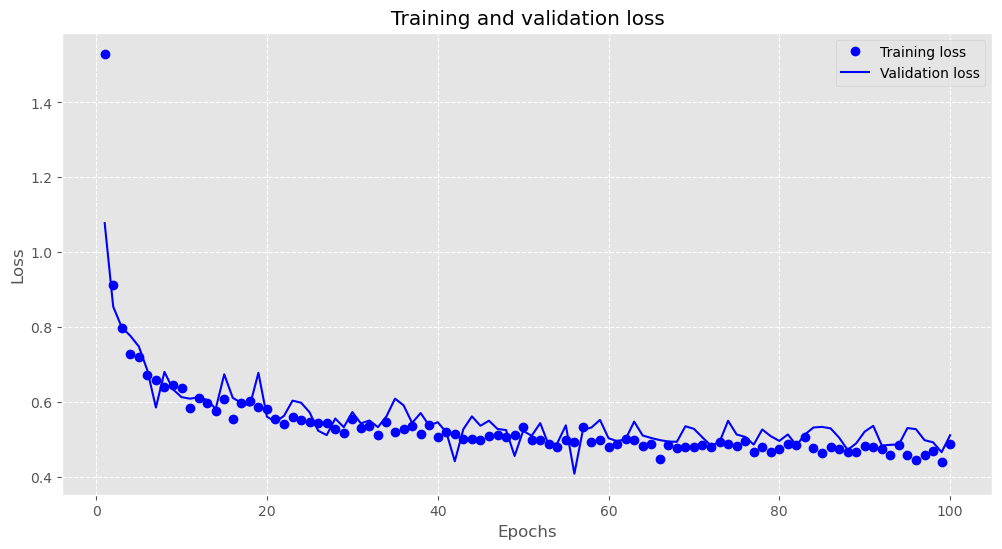

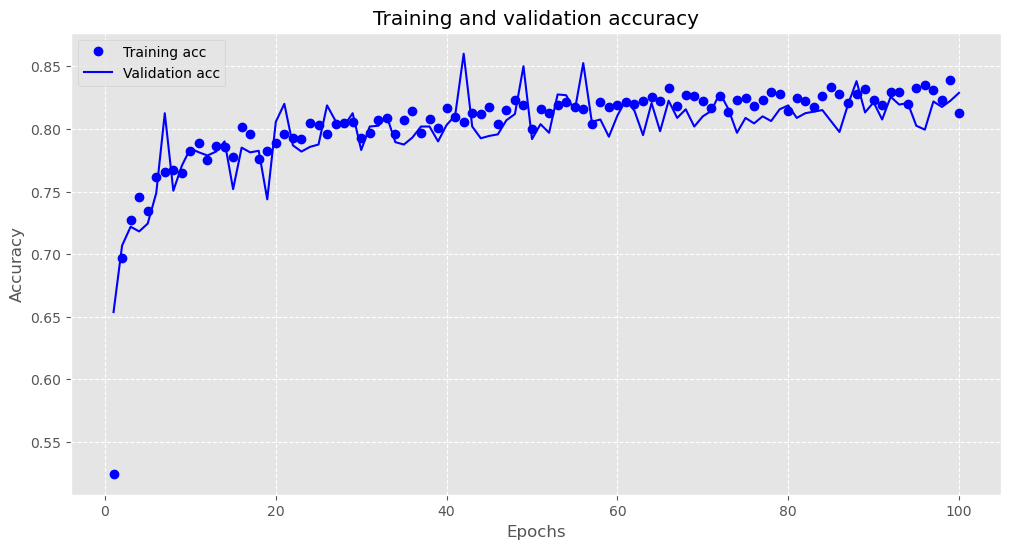

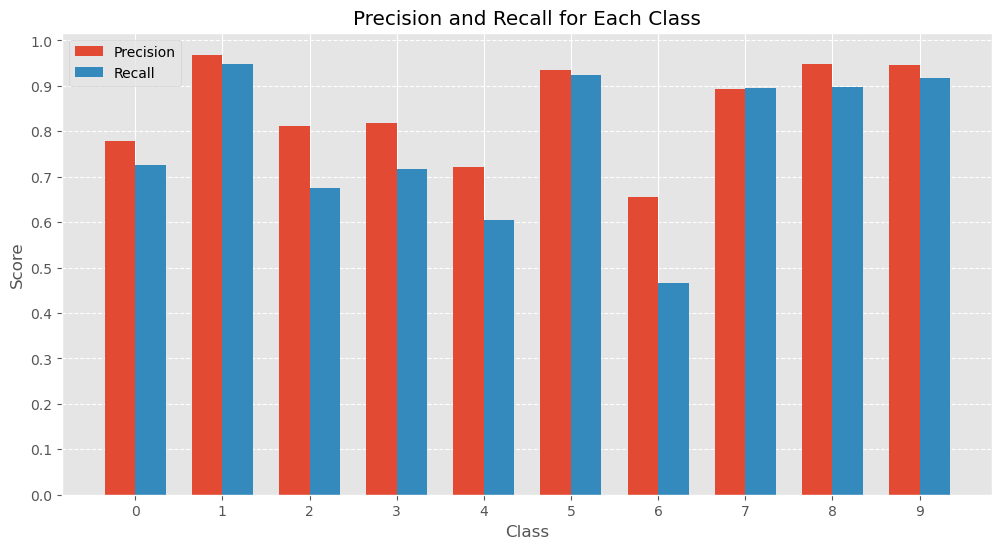

In [11]:
plot_history(history)
plot_precision_recall(history)

In [ ]:
model_filter.save("D:\\My_Projects_Python\\HW_Data_Science\\models\\fashion_model_feature_extraction.keras")

In [12]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block4_conv3":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

class MyModifiedModel():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(
                units=64,
                activation='relu'
            ),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model

In [13]:

history = model_filter.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=50,
    epochs=100,
    batch_size=32
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8441 - loss: 0.4350 - precision_class_0: 0.8252 - precision_class_1: 0.9777 - precision_class_2: 0.8270 - precision_class_3: 0.8556 - precision_class_4: 0.7233 - precision_class_5: 0.9492 - precision_class_6: 0.7603 - precision_class_7: 0.8860 - precision_class_8: 0.9512 - precision_class_9: 0.9380 - recall_class_0: 0.7627 - recall_class_1: 0.9370 - recall_class_2: 0.6287 - recall_class_3: 0.7723 - recall_class_4: 0.7195 - recall_class_5: 0.9038 - recall_class_6: 0.4253 - recall_class_7: 0.9247 - recall_class_8: 0.9090 - recall_class_9: 0.9042 - val_accuracy: 0.8112 - val_loss: 0.5170 - val_precision_class_0: 0.7868 - val_precision_class_1: 0.9688 - val_precision_class_2: 0.7468 - val_precision_class_3: 0.7941 - val_precision_class_4: 0.7755 - val_precision_class_5: 0.9116 - val_precision_class_6: 0.6869 - val_precision_class_7: 0.9221 - val_precision_class_8: 0.9020 - val_precision_class_9: 0.9467 - val_recall_class_0

2024-02-19 16:34:10.350035: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-02-19 16:34:10.350068: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8074 - loss: 0.4897 - precision_class_0: 0.7821 - precision_class_1: 0.9816 - precision_class_2: 0.7909 - precision_class_3: 0.8242 - precision_class_4: 0.6983 - precision_class_5: 0.9232 - precision_class_6: 0.6530 - precision_class_7: 0.9016 - precision_class_8: 0.9333 - precision_class_9: 0.9223 - recall_class_0: 0.7677 - recall_class_1: 0.9301 - recall_class_2: 0.6787 - recall_class_3: 0.7572 - recall_class_4: 0.6241 - recall_class_5: 0.8956 - recall_class_6: 0.4285 - recall_class_7: 0.8868 - recall_class_8: 0.8481 - recall_class_9: 0.9406 - val_accuracy: 0.8200 - val_loss: 0.4733 - val_precision_class_0: 0.8194 - val_precision_class_1: 0.9862 - val_precision_class_2: 0.8105 - val_precision_class_3: 0.8200 - val_precision_class_4: 0.7687 - val_precision_class_5: 0.9137 - val_precision_class_6: 0.6250 - val_precision_class_7: 0.9231 - val_precision_class_8: 0.9504 - val_precision_class_9: 0.9639 - val_recall_class_0: 0.7468 - v

2024-02-19 16:34:22.047122: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8363 - loss: 0.4420 - precision_class_0: 0.7990 - precision_class_1: 0.9783 - precision_class_2: 0.8196 - precision_class_3: 0.8522 - precision_class_4: 0.7735 - precision_class_5: 0.9567 - precision_class_6: 0.7606 - precision_class_7: 0.8885 - precision_class_8: 0.9554 - precision_class_9: 0.9295 - recall_class_0: 0.7633 - recall_class_1: 0.9650 - recall_class_2: 0.7316 - recall_class_3: 0.8201 - recall_class_4: 0.6954 - recall_class_5: 0.9256 - recall_class_6: 0.4059 - recall_class_7: 0.9128 - recall_class_8: 0.9042 - recall_class_9: 0.9094 - val_accuracy: 0.8250 - val_loss: 0.4781 - val_precision_class_0: 0.7836 - val_precision_class_1: 0.9713 - val_precision_class_2: 0.8923 - val_precision_class_3: 0.8333 - val_precision_class_4: 0.7885 - val_precision_class_5: 0.9571 - val_precision_class_6: 0.6186 - val_precision_class_7: 0.9012 - val_precision_class_8: 0.9176 - val_precision_class_9: 0.9529 - val_recall_class_0: 0.6562 - v

2024-02-19 16:34:30.429243: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8359 - loss: 0.4412 - precision_class_0: 0.8465 - precision_class_1: 0.9789 - precision_class_2: 0.8500 - precision_class_3: 0.8309 - precision_class_4: 0.7193 - precision_class_5: 0.9149 - precision_class_6: 0.6885 - precision_class_7: 0.9205 - precision_class_8: 0.9818 - precision_class_9: 0.9549 - recall_class_0: 0.7524 - recall_class_1: 0.9596 - recall_class_2: 0.6758 - recall_class_3: 0.7841 - recall_class_4: 0.5967 - recall_class_5: 0.9183 - recall_class_6: 0.4220 - recall_class_7: 0.8960 - recall_class_8: 0.9126 - recall_class_9: 0.9562 - val_accuracy: 0.8144 - val_loss: 0.5107 - val_precision_class_0: 0.7544 - val_precision_class_1: 0.9940 - val_precision_class_2: 0.7946 - val_precision_class_3: 0.7899 - val_precision_class_4: 0.7612 - val_precision_class_5: 0.9227 - val_precision_class_6: 0.6055 - val_precision_class_7: 0.8926 - val_precision_class_8: 0.9733 - val_precision_class_9: 0.9423 - val_recall_class_0: 0.7914 - v

2024-02-19 16:34:34.136515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8289 - loss: 0.4724 - precision_class_0: 0.8065 - precision_class_1: 0.9635 - precision_class_2: 0.7819 - precision_class_3: 0.8314 - precision_class_4: 0.7994 - precision_class_5: 0.9271 - precision_class_6: 0.6878 - precision_class_7: 0.9159 - precision_class_8: 0.9096 - precision_class_9: 0.9137 - recall_class_0: 0.6915 - recall_class_1: 0.9600 - recall_class_2: 0.6794 - recall_class_3: 0.7844 - recall_class_4: 0.6900 - recall_class_5: 0.8813 - recall_class_6: 0.4356 - recall_class_7: 0.9159 - recall_class_8: 0.9272 - recall_class_9: 0.9206 - val_accuracy: 0.8163 - val_loss: 0.5271 - val_precision_class_0: 0.8254 - val_precision_class_1: 0.9737 - val_precision_class_2: 0.7615 - val_precision_class_3: 0.7882 - val_precision_class_4: 0.7826 - val_precision_class_5: 0.8563 - val_precision_class_6: 0.6975 - val_precision_class_7: 0.9241 - val_precision_class_8: 0.9247 - val_precision_class_9: 0.9699 - val_recall_class_0: 0.6420 - v

2024-02-19 16:35:21.055844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:35:21.055879: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8365 - loss: 0.4415 - precision_class_0: 0.8593 - precision_class_1: 0.9811 - precision_class_2: 0.8416 - precision_class_3: 0.8250 - precision_class_4: 0.7803 - precision_class_5: 0.9439 - precision_class_6: 0.6782 - precision_class_7: 0.8543 - precision_class_8: 0.9221 - precision_class_9: 0.9394 - recall_class_0: 0.7911 - recall_class_1: 0.9558 - recall_class_2: 0.7016 - recall_class_3: 0.7980 - recall_class_4: 0.6472 - recall_class_5: 0.9048 - recall_class_6: 0.4797 - recall_class_7: 0.8633 - recall_class_8: 0.9213 - recall_class_9: 0.9196 - val_accuracy: 0.8156 - val_loss: 0.4994 - val_precision_class_0: 0.7818 - val_precision_class_1: 0.9800 - val_precision_class_2: 0.7869 - val_precision_class_3: 0.8417 - val_precision_class_4: 0.6842 - val_precision_class_5: 0.9524 - val_precision_class_6: 0.7000 - val_precision_class_7: 0.8659 - val_precision_class_8: 0.9574 - val_precision_class_9: 0.9434 - val_recall_class_0: 0.8165 - v

2024-02-19 16:35:33.376270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8463 - loss: 0.4176 - precision_class_0: 0.7979 - precision_class_1: 0.9929 - precision_class_2: 0.8334 - precision_class_3: 0.8912 - precision_class_4: 0.7680 - precision_class_5: 0.9555 - precision_class_6: 0.6902 - precision_class_7: 0.9173 - precision_class_8: 0.9482 - precision_class_9: 0.9677 - recall_class_0: 0.7982 - recall_class_1: 0.9654 - recall_class_2: 0.7191 - recall_class_3: 0.8593 - recall_class_4: 0.5941 - recall_class_5: 0.9627 - recall_class_6: 0.4348 - recall_class_7: 0.9019 - recall_class_8: 0.9197 - recall_class_9: 0.9329 - val_accuracy: 0.8375 - val_loss: 0.4495 - val_precision_class_0: 0.8455 - val_precision_class_1: 0.9874 - val_precision_class_2: 0.8601 - val_precision_class_3: 0.7922 - val_precision_class_4: 0.7636 - val_precision_class_5: 0.9662 - val_precision_class_6: 0.6301 - val_precision_class_7: 0.8970 - val_precision_class_8: 0.9805 - val_precision_class_9: 0.9576 - val_recall_class_0: 0.7075 - v

2024-02-19 16:35:55.509459: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:35:55.509488: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8378 - loss: 0.4270 - precision_class_0: 0.8232 - precision_class_1: 0.9669 - precision_class_2: 0.8324 - precision_class_3: 0.8505 - precision_class_4: 0.7137 - precision_class_5: 0.9438 - precision_class_6: 0.7735 - precision_class_7: 0.9101 - precision_class_8: 0.9604 - precision_class_9: 0.9341 - recall_class_0: 0.7441 - recall_class_1: 0.9401 - recall_class_2: 0.6867 - recall_class_3: 0.7622 - recall_class_4: 0.6469 - recall_class_5: 0.9358 - recall_class_6: 0.5949 - recall_class_7: 0.9137 - recall_class_8: 0.9225 - recall_class_9: 0.9429 - val_accuracy: 0.8225 - val_loss: 0.5107 - val_precision_class_0: 0.8082 - val_precision_class_1: 0.9379 - val_precision_class_2: 0.7396 - val_precision_class_3: 0.8931 - val_precision_class_4: 0.7431 - val_precision_class_5: 0.9597 - val_precision_class_6: 0.6000 - val_precision_class_7: 0.9367 - val_precision_class_8: 0.9433 - val_precision_class_9: 0.9315 - val_recall_class_0: 0.7329 - v

2024-02-19 16:36:04.984465: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835
2024-02-19 16:36:04.984500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13073093240666798960


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8533 - loss: 0.3996 - precision_class_0: 0.8274 - precision_class_1: 0.9952 - precision_class_2: 0.8413 - precision_class_3: 0.8633 - precision_class_4: 0.7057 - precision_class_5: 0.9506 - precision_class_6: 0.7144 - precision_class_7: 0.9300 - precision_class_8: 0.9722 - precision_class_9: 0.9536 - recall_class_0: 0.8059 - recall_class_1: 0.9712 - recall_class_2: 0.7381 - recall_class_3: 0.7805 - recall_class_4: 0.6331 - recall_class_5: 0.9278 - recall_class_6: 0.4879 - recall_class_7: 0.9276 - recall_class_8: 0.9390 - recall_class_9: 0.9500 - val_accuracy: 0.8181 - val_loss: 0.5096 - val_precision_class_0: 0.8217 - val_precision_class_1: 0.9928 - val_precision_class_2: 0.7193 - val_precision_class_3: 0.8247 - val_precision_class_4: 0.7040 - val_precision_class_5: 0.9762 - val_precision_class_6: 0.7188 - val_precision_class_7: 0.8720 - val_precision_class_8: 0.9463 - val_precision_class_9: 0.9496 - val_recall_class_0: 0.7679 - v

2024-02-19 16:36:18.516168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8488 - loss: 0.4053 - precision_class_0: 0.8263 - precision_class_1: 0.9807 - precision_class_2: 0.8453 - precision_class_3: 0.8606 - precision_class_4: 0.7571 - precision_class_5: 0.9467 - precision_class_6: 0.7539 - precision_class_7: 0.8944 - precision_class_8: 0.9750 - precision_class_9: 0.9592 - recall_class_0: 0.7489 - recall_class_1: 0.9692 - recall_class_2: 0.7168 - recall_class_3: 0.8346 - recall_class_4: 0.7206 - recall_class_5: 0.9187 - recall_class_6: 0.4584 - recall_class_7: 0.9212 - recall_class_8: 0.9022 - recall_class_9: 0.9098 - val_accuracy: 0.8238 - val_loss: 0.4939 - val_precision_class_0: 0.7784 - val_precision_class_1: 0.9688 - val_precision_class_2: 0.8605 - val_precision_class_3: 0.8025 - val_precision_class_4: 0.7218 - val_precision_class_5: 0.9070 - val_precision_class_6: 0.6436 - val_precision_class_7: 0.9209 - val_precision_class_8: 0.9589 - val_precision_class_9: 0.9799 - val_recall_class_0: 0.7927 - v

2024-02-19 16:36:30.407185: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2479668310719670835


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8459 - loss: 0.4295 - precision_class_0: 0.7908 - precision_class_1: 0.9769 - precision_class_2: 0.8007 - precision_class_3: 0.8571 - precision_class_4: 0.7319 - precision_class_5: 0.9334 - precision_class_6: 0.7519 - precision_class_7: 0.9126 - precision_class_8: 0.9548 - precision_class_9: 0.9682 - recall_class_0: 0.8158 - recall_class_1: 0.9351 - recall_class_2: 0.6667 - recall_class_3: 0.8019 - recall_class_4: 0.6598 - recall_class_5: 0.9340 - recall_class_6: 0.5869 - recall_class_7: 0.9100 - recall_class_8: 0.9281 - recall_class_9: 0.9689 - val_accuracy: 0.7994 - val_loss: 0.5235 - val_precision_class_0: 0.7238 - val_precision_class_1: 0.9470 - val_precision_class_2: 0.7252 - val_precision_class_3: 0.8598 - val_precision_class_4: 0.7731 - val_precision_class_5: 0.9675 - val_precision_class_6: 0.5714 - val_precision_class_7: 0.8603 - val_precision_class_8: 0.9805 - val_precision_class_9: 0.9581 - val_recall_class_0: 0.7751 - v

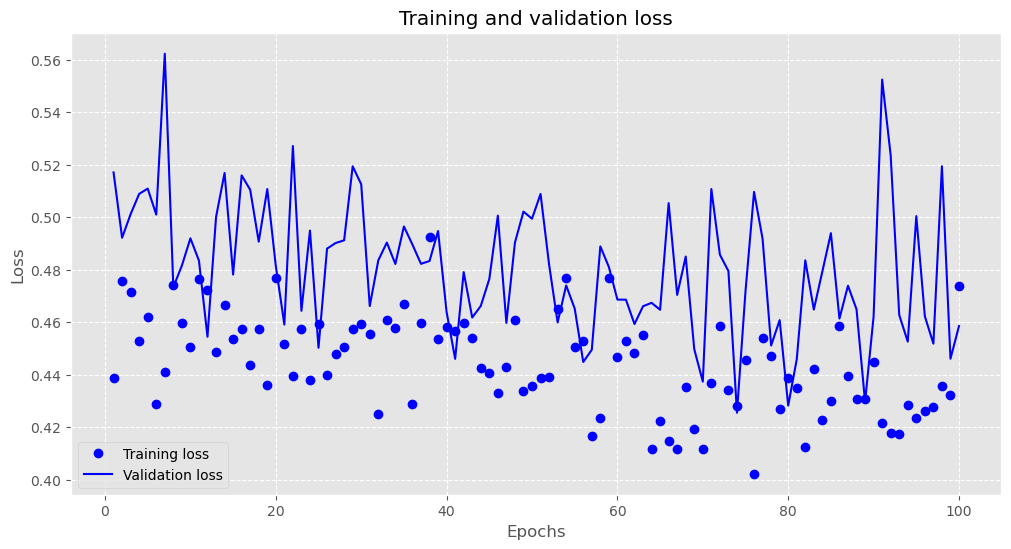

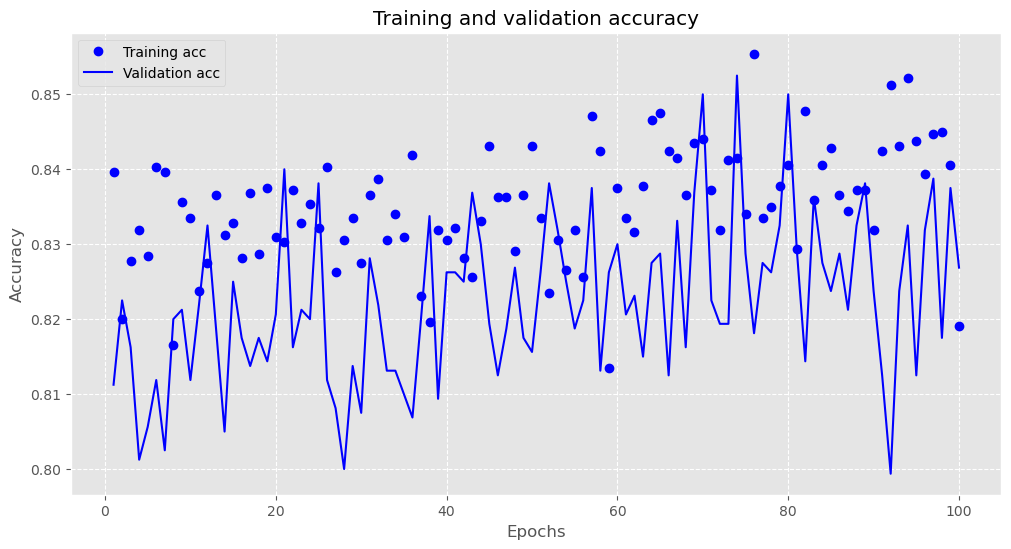

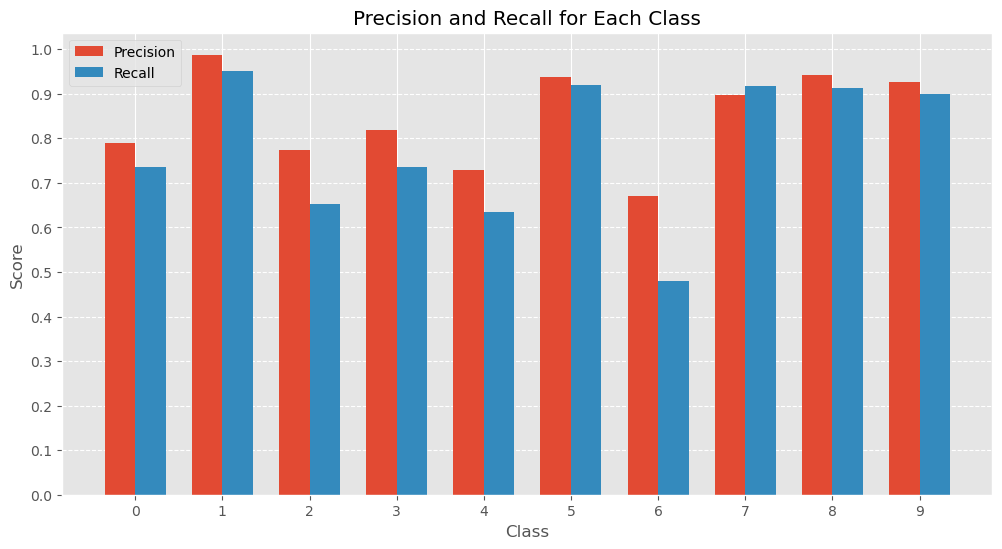

In [14]:
plot_history(history)
plot_precision_recall(history)

In [16]:
test_acc = model_filter.evaluate(test_generator, steps=50)
print("test acc:", test_acc[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8223 - loss: 0.4664 - precision_class_0: 0.9165 - precision_class_1: 0.9403 - precision_class_2: 0.8409 - precision_class_3: 0.9028 - precision_class_4: 0.7739 - precision_class_5: 0.9630 - precision_class_6: 0.6005 - precision_class_7: 0.8608 - precision_class_8: 0.9763 - precision_class_9: 0.9369 - recall_class_0: 0.6730 - recall_class_1: 0.9707 - recall_class_2: 0.6511 - recall_class_3: 0.6904 - recall_class_4: 0.7123 - recall_class_5: 0.8388 - recall_class_6: 0.6538 - recall_class_7: 0.9511 - recall_class_8: 0.8595 - recall_class_9: 0.9379
test acc: 0.8181250095367432


# Висновки:

З-за допомогою передвиборних мереж мені не вдалося покращити результат попередньої моделі